# Abstract

(Just a sketch) Green's functions and their fourier transform are very useful entities, due to being directly measurable as physical quantities like the spectral function or the susceptibilty and being able to model complex many-body interactions using two-, three- and four-point functions. Due to these calculations being very costly, an intermediate representation of the Green's functions between matsubara frequency and time domain was developed. An advantage of this is a fast and efficient way to retrieve both function variants. This work compares several simpler approaches to geth the Fourier transform to the one using intermediate representations for two- and three-point functions. Afterwards, it is applied in a practical example.


# Introduction

The code for this work is written in Julia, using the library Fermions.jl. it models concepts for the second quantization like Fock-spaces, operators, solvers and much more for fermionic particles. First, four basic libraries are imported.

In [1]:
using Fermions
using LinearAlgebra
using Fermions.Aux
using Plots

# Three-Point Propagator Function

In [2]:
function G_ABC_n_ord_Lehmann1(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, τ1::Array{T,1},τ2::Array{T,1},β::Real) where T <: Real
    val_arr = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(τ1), j in 1:length(τ2)
        if τ1[i] >= τ2[j]
            val_arr[i,j] = 0 + 0im
            for m in 1:length(ϵ), s in 1:length(ϵ)
                val_arr[i,j] += dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*
                dot(Ψn[:,s],C*n)*exp(-ϵ[m]*(τ1[i]-τ2[j])-ϵ[s]*τ2[j])
            end
            val_arr[i,j] *= exp(-ϵ_n*(β-τ1[i]))
        else #τ2 > τ1
            val_arr[i,j] = 0 + 0im
            for m in 1:length(ϵ), s in 1:length(ϵ)
                val_arr[i,j] += dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*
                dot(Ψn[:,s],C*n)*exp(-ϵ[m]*(τ2[j]-τ1[i])-ϵ[s]*τ1[i])
            end
            if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
                val_arr[i,j] *= -1.0*exp(-ϵ_n*(β-τ2[j]))
            else
                val_arr[i,j] *= exp(-ϵ_n*(β-τ2[j]))
            end
        end
    end
    return val_arr
end

function G_ABC_Lehmann1(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real) where T <: Real
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result=G_ABC_n_ord_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],τ1,τ2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann1(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],τ1,τ2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann1 (generic function with 1 method)

We reuse this code for our representation of the analytically transformed Lehmann representation:

In [3]:
function G_ABC_n_ord_Lehmann(Ψn::Array{Complex{T},2},ϵ::Array{T,1},ϵ_n::Real, A::Operator,B::Operator,
    C::Operator,n::Array{Complex{T},1}, ω1::Array{T,1},ω2::Array{T,1},β::Real) where T <: Real
    val_arr1 = zeros(length(ω1),length(ω2)) .+ 0im
    for i in 1:length(ω1), j in 1:length(ω2)

        val_arr1[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            product = dot(n,A*Ψn[:,m])*dot(Ψn[:,m],B*Ψn[:,s])*dot(Ψn[:,s],C*n)* (1/(ϵ[s]-ϵ[m]-im*ω2[j]))
            if (ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]) == 0
                sometimes_zero_term = -β
            else
                sometimes_zero_term = 1/(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])*(exp(-β*(ϵ[s]-ϵ_n))-1)
            end
            
            product = product * (sometimes_zero_term+1/(ϵ[m]-ϵ_n-im*ω1[i])*(exp(-β*(ϵ[m]-ϵ_n))+1))
            val_arr1[i,j] += product
            #*exp(-ϵ[m]*(τ1[i]-τ2[j])-ϵ[s]*τ2[j])
        end
        val_arr1[i,j] *= exp(-ϵ_n*β)
    end
    val_arr2 = zeros(length(ω1),length(ω2)) .+ 0im
    for i in 1:length(ω1), j in 1:length(ω2)
        
        val_arr2[i,j] = 0 + 0im
        for m in 1:length(ϵ), s in 1:length(ϵ)
            product = dot(n,B*Ψn[:,m])*dot(Ψn[:,m],A*Ψn[:,s])*dot(Ψn[:,s],C*n)* (1/(ϵ[s]-ϵ[m]-im*ω1[i])) 
            if (ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j]) == 0
                sometimes_zero_term = -β
            else
                sometimes_zero_term = 1/(ϵ[s]-ϵ_n-im*ω1[i]-im*ω2[j])*(exp(-β*(ϵ[s]-ϵ_n))-1)
            end
            
            product = product * (sometimes_zero_term+1/(ϵ[m]-ϵ_n-im*ω2[j]) * (exp(-β*(ϵ[m]-ϵ_n))+1))
            val_arr2[i,j] += product
            #*exp(-ϵ[m]*(τ2[j]-τ1[i])-ϵ[s]*τ1[i])
        end
        if wick_parity(A) * wick_parity(B) == 1 #two fermionic Operators
            val_arr2[i,j] *= -1.0*exp(-ϵ_n*β)
        else
            val_arr2[i,j] *= exp(-ϵ_n*β)
        end
    end
    return val_arr1+val_arr2
end

function G_ABC_Lehmann(A::Operator, B::Operator,C::Operator, τ1::Array{T,1},
    τ2::Array{T,1},H::Operator,β::Real, n_max1::Integer, n_max2::Integer) where T <: Real
    
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    H_eigvec = eigvecs(Array(H)) .+ 0im
    H_eigene = eigvals(Array(H))
    H_eigene = H_eigene .- H_eigene[1] #shift spectrum
    Z = 0
    result = zeros(length(τ1),length(τ2)) .+ 0im
    for i in 1:length(H_eigene)
        if i == 1
            result=G_ABC_n_ord_Lehmann(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        else
            result=result .+ G_ABC_n_ord_Lehmann(H_eigvec,H_eigene,H_eigene[i],A,B,C,H_eigvec[:,i],ω1,ω2,β)
        end
        Z += exp(-β*H_eigene[i])
    end
    result = -1.0 .* result ./ Z
    return result
end

G_ABC_Lehmann (generic function with 1 method)

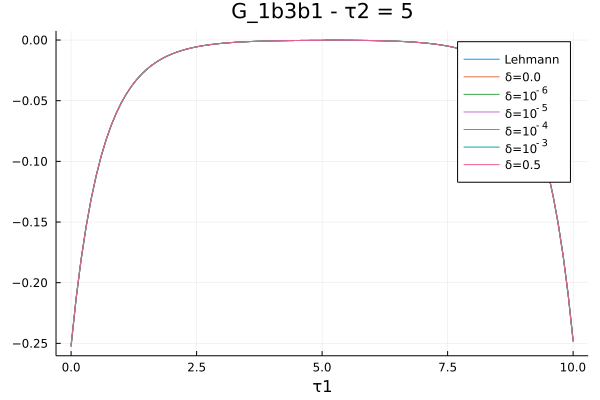

In [4]:
space3 = FockSpace(4)
c3 = annihilators(space3)
H3 = Hubbard(space3,3.,-1.,1.5)
β3 = 10.
A3 = Operator(space3)
A3 += 1.0 * c3[1]
B3 = Operator(space3)
B3 += 1.0 * c3[3]'*c3[3]
C3 = Operator(space3)
C3 += 1.0 * c3[1]'
τ1_arr = [0.0]
τ2_arr = [0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0]
for i in 1:100
    push!(τ1_arr,i/10)
end
G_1b3b1_Lehmann = real(G_ABC_Lehmann1(A3,B3,C3,τ1_arr,τ2_arr,H3,β3)[:,:])
G_1b3b1_00 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.0)[:,:])
G_1b3b1_0000001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.000001)[:,:])
G_1b3b1_000001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.00001)[:,:])
G_1b3b1_00001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.0001)[:,:])
G_1b3b1_0001 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.001)[:,:])
G_1b3b1_05 = real(G_ABC(A3,B3,C3,τ1_arr,τ2_arr,H3,β3,space3,0.5)[:,:])
plot(τ1_arr,[G_1b3b1_Lehmann[:,6],G_1b3b1_00[:,6],G_1b3b1_0000001[:,6],G_1b3b1_000001[:,6],G_1b3b1_00001[:,6],G_1b3b1_0001[:,6],G_1b3b1_05[:,6]],title = "G_1b3b1 - τ2 = 5", label = ["Lehmann" "δ=0.0" "δ=10^{-6}" "δ=10^{-5}" "δ=10^{-4}" "δ=10^{-3}" "δ=0.5"], lw = 1, xlabel = "τ1",fmt = :png)


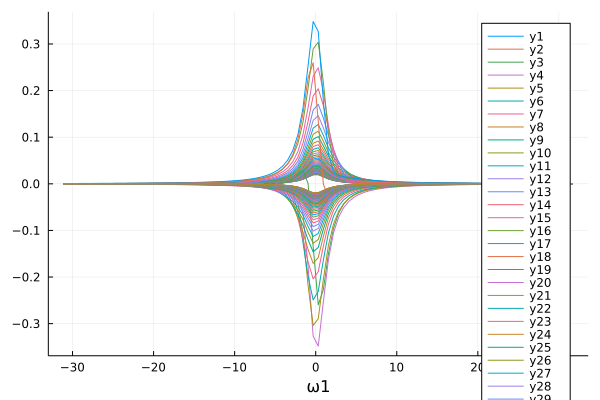

In [5]:
n_max3 = 50
n_max = n_max3
n3 = collect(-n_max:1:n_max)
n=n3
β = β3
ω3 = (2n.+1)*π/β

lehmann3 = G_ABC_Lehmann(A3,B3,C3,τ1_arr,τ2_arr,H3,β3, n_max3, n_max3)[:,:]
transform3_Lehmann = imag(lehmann3)
transform3_Lehmann_real = real(lehmann3)

plot(ω3, transform3_Lehmann, lw = 1, xlabel = "ω1",fmt = :png)

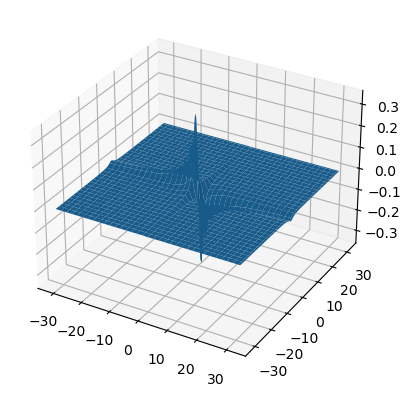

PyObject <mpl_toolkits.mplot3d.art3d.Poly3DCollection object at 0x0000000001472340>

In [6]:
using PyPlot;
surf(ω3, ω3, transform3_Lehmann)

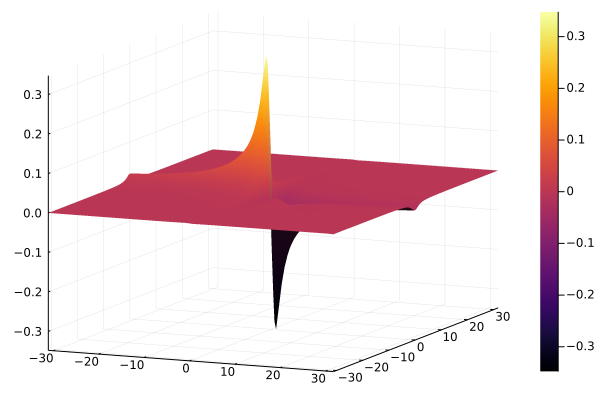

In [7]:
plot(ω3, ω3, transform3_Lehmann, st=:surface)

Again: Integral as a Sum

\begin{align}
    G(\omega_{\nu}, \omega_{\mu}) \approx \sum_{l} \sum_{j} e^{i \omega_{\nu} \tau_l} e^{i \omega_{\mu} \tau_j} G(\tau_l, \tau_j) \Delta \tau_j \Delta \tau_l
\end{align}

In [8]:
# goal 1 again
function G_ABC_transform(A, B, C, τ_arr1, τ_arr2, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    Δτ1 = (β/size(τ_arr1)[1])
    Δτ2 = (β/size(τ_arr2)[1])
    
    matrix1 = ℯ.^(im*ω1*transpose(τ_arr1))
    result = Δτ1*matrix1*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)
    
    matrix2 = ℯ.^(im*ω2*transpose(τ_arr2))
    result = Δτ2*matrix2*transpose(result)
    return transpose(result)
end


function G_ABC_transform_saved(G_THREE, τ_arr1, τ_arr2, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    dimtau1 = size(τ_arr1)[1]
    dimtau2 = size(τ_arr2)[1]
    dimG1 = size(G_THREE)[1]
    dimG2 = size(G_THREE)[2]  
    stepsizet1 = max(trunc(Int,dimG1/dimtau1),1)
    stepsizet2 = max(trunc(Int,dimG2/dimtau2),1)
    stepsizeinv1 = max(trunc(Int,dimtau1/dimG1),1)
    stepsizeinv2 = max(trunc(Int,dimtau2/dimG2),1)
    
    Δτ1 = (β/size(τ_arr1[begin:stepsizeinv1:end])[1])
    Δτ2 = (β/size(τ_arr2[begin:stepsizeinv2:end])[1])
    matrix1 = ℯ.^(im*ω1*transpose(τ_arr1[begin:stepsizeinv1:end]))
    result = Δτ1*matrix1*G_THREE[begin:stepsizet1:end,begin:stepsizet2:end]
    matrix2 = ℯ.^(im*ω2*transpose(τ_arr2[begin:stepsizeinv2:end]))
    result = Δτ2*matrix2*transpose(result)
    #println((Δτ1))
    #println(size(matrix1))
    #println(size(G_THREE[begin:stepsizet1:end,begin:stepsizet2:end]))
    #println(size(result))
    return transpose(result)
end

G_ABC_transform_saved (generic function with 1 method)

In [9]:
# make delta tau smaller!
τ_arr = collect(0.:0.01:β-0.01)

##greenfunction3 = G_ABC(A3,B3,C3,τ_arr,τ_arr,H3,β3,space3,0.0)
transform3 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))

plot(ω,transform3,
    title = "Transform", 
    label = ["transform"], 
    lw = 1, xlabel = "ω_n", ylabel = "G(iω_n)", fmt = :png)

LoadError: UndefVarError: greenfunction3 not defined

In [10]:
surf(ω3, ω3, transform3)

LoadError: UndefVarError: transform3 not defined

plot(ω3, ω3, transform3_Lehmann, st=:surface)

In [11]:
plot(ω3, ω3, transform3, st=:surface)



LoadError: UndefVarError: transform3 not defined

In [12]:
τ_arr = collect(0.:0.001:β-0.001)

##greenfunction3 = G_ABC(A3,B3,C3,τ_arr,τ_arr,H3,β3,space3,0.0)
   





10000-element Vector{Float64}:
 0.0
 0.001
 0.002
 0.003
 0.004
 0.005
 0.006
 0.007
 0.008
 0.009
 0.01
 0.011
 0.012
 ⋮
 9.988
 9.989
 9.99
 9.991
 9.992
 9.993
 9.994
 9.995
 9.996
 9.997
 9.998
 9.999

In [13]:

τ_arr = collect(0.:0.1:β-0.1)
transform3_0_1 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.05:β-0.05)
transform3_0_05 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.01:β-0.01)
transform3_0_01 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))
τ_arr = collect(0.:0.001:β-0.001)
transform3_0_001 = imag(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))


τ_arr = collect(0.:0.001:β-0.001)
transform3_0_001_real = real(G_ABC_transform_saved(greenfunction3, τ_arr, τ_arr, H3, β3, space3, n_max3, n_max3))

x_cut = 25

plot(ω3, transform3_0_1[x_cut,:], label = ["100 points"])
plot!(ω3, transform3_0_05[x_cut,:], label = ["200 points"])
plot!(ω3, transform3_0_01[x_cut,:], label = ["1000 points"])
#plot!(ω3, transform3_0_001[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann[x_cut,:], label = ["analytical"])

println(size(transform3_Lehmann))

LoadError: UndefVarError: greenfunction3 not defined

## 

In [14]:
x_cut = 1

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [15]:
x_cut = 25

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [16]:
x_cut = 50

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [17]:
x_cut = 75

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [18]:
x_cut = 100

plot(ω3, transform3_0_001_real[x_cut,:], label = ["10000 points"])
plot!(ω3, transform3_Lehmann_real[x_cut,:], label = ["analytical"])

LoadError: UndefVarError: transform3_0_001_real not defined

In [19]:
println(ω3[1])
println(ω3[25])
println(ω3[50])
println(ω3[75])
println(ω3[100])

-31.101767270538954
-16.022122533307943
-0.3141592653589793
15.393804002589984
31.101767270538954


In [20]:
plot(ω3, ω3, transform3_0_001, st=:surface)

LoadError: UndefVarError: transform3_0_001 not defined

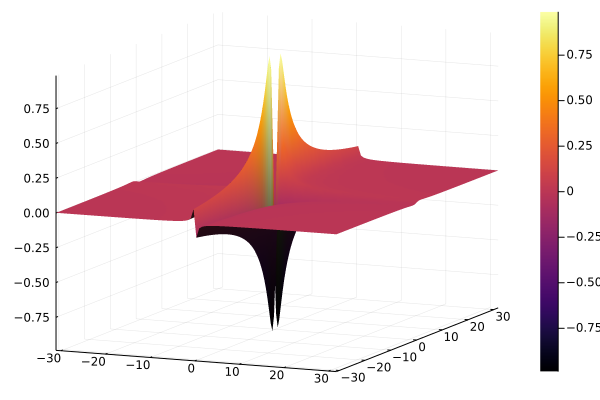

In [21]:
plot(ω3, ω3, transform3_Lehmann_real, st=:surface)

Goal 2: Integral with Gauss-Legendre but 2D, something like:

\begin{align}
    G(i \omega_n) \approx \sum_{j} \omega_j e^{i \omega_n \tau_j} G(\tau_j) \Delta \tau
\end{align}

In [22]:
# goal 2

using Cuba, SpecialFunctions

function G_ABC_gl_part(A, B, C, H, β, space, ω1, ω2)
    #return transpose(Δτ2*ℯ.^(im*ω2*transpose(τ_arr2))*transpose(Δτ1*ℯ.^(im*ω1*transpose(τ_arr1))*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)))
    function integrand(x, f)
        #temp=transpose(ℯ.^(im*ω2*transpose(x[2]*β))*transpose(ℯ.^(im*ω1*transpose(x[1]*β))
        #        *G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.0)[1,1]))
        temp=ℯ.^(im*ω2*(x[2]*β))*ℯ.^(im*ω1*(x[1]*β))*G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.05)[1,1]
        #temp=1
        f[1],f[2]=reim(temp)
        #f[1]=im*x[1]
    end
    #result, err = cuhre(integrand, 2, 2, atol=1e-12, rtol=1e-10);
    result, err = cuhre(integrand, 2, 2, atol=1e-3, rtol=1e-2);
    return complex(result[1],result[2])
end

function G_ABC_gl_transform(A, B, C, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    τ_arr_expl = collect(0.:0.01:β-0.01)

    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    
            I = G_ABC_gl_part(A, B, C, H, β, space, ω1[j], ω2[k])
            #I=4
            println("Done with ", j, ", ", k)
            result[j,k] = I
        end
    end
    
    return result
end


G_ABC_gl_transform (generic function with 1 method)

τ_arr_expl = collect(0.:0.01:β-0.01)
#I, w = G_ABC_gl_part_tau1(A3, B3, C3, H3, β3, space3, ω3[1], ω3[1], τ_arr_expl)

typeof(I)
I
I[1]
typeof(zero(ComplexF64))
typeof(I[1])

In [23]:
    n2 = collect(-20:1:20)
    ω2 = (2n2.+1)*π/β
length(ω2)

41

In [24]:

using Cuba, SpecialFunctions

#transform3_cuhre = (G_ABC_gl_transform(A3, B3, C3, H3, β3, space3, n_max3, n_max3))

#transform3_cuhre_imag = imag(transform3_cuhre)

In [25]:
plot(ω3, ω3, real(transform3_cuhre), st=:surface)


LoadError: UndefVarError: transform3_cuhre not defined

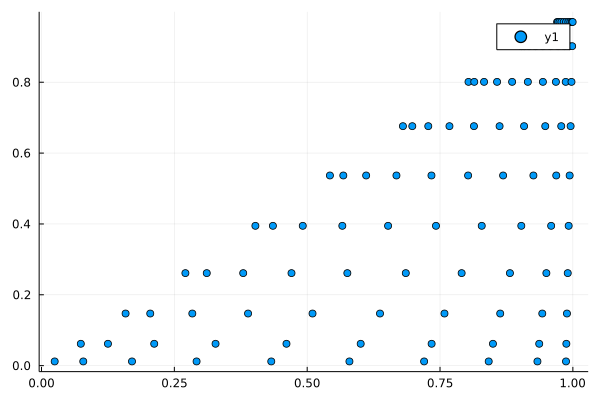

In [26]:
using SimplexQuad

X, W = simplexquad(10, 2)

function f(x,y)
    return sin.(x.*5).+y
end

#Integral = sum(W[i] * f(1 .-X[i,:]) for i in 1:length(W))

Y=1 .-X
#plot(1 .-Y[:,1],Y[:,2],seriestype=:scatter)

plot(1 .-X[:,1],X[:,2],seriestype=:scatter)

#Y[:,:]
#sum(W[i] * f(1 .-Y[i,1], Y[i,2]) for i in 1:length(W))+sum(W[i] * f(1 .-X[i,1],X[i,2]) for i in 1:length(W))

#using PyPlot;
#surf(1 .-X[:,1], X[:,2], f(1 .-X[:,1],X[:,2]))
#surf(1 .-Y[:,1], Y[:,2], f(1 .-Y[:,1],Y[:,2]))



#plot(1 .-X[:,1], X[:,2], f(1 .-X[:,1],X[:,2]), st=:surface)
#plot!(1 .-Y[:,1], Y[:,2], f(1 .-Y[:,1],Y[:,2]), st=:surface)


#using PyPlot;
#surf(1 .-X[:,1], X[:,2], f(1 .-X[:,1],X[:,2]))
#surf(vcat(1 .-X[:,1],1 .-Y[:,1]), vcat(X[:,2],Y[:,2]), vcat(f(1 .-X[:,1],X[:,2]),f(1 .-Y[:,1],Y[:,2])))

#sum(W[i] * f(1 .-Y[i,1], Y[i,2]) for i in 1:length(W))+sum(W[i] * f(1 .-X[i,1],X[i,2]) for i in 1:length(W))


plot(1 .-X[:,1],X[:,2],seriestype=:scatter)

In [27]:
# split the area into two simplices

using SimplexQuad

function G_ABC_gl_part_simplex(A, B, C, H, β, space, ω1, ω2, X1, X2)
    x = [X1, X2]
    #return transpose(Δτ2*ℯ.^(im*ω2*transpose(τ_arr2))*transpose(Δτ1*ℯ.^(im*ω1*transpose(τ_arr1))*G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)))

    temp=ℯ.^(im*ω2*(x[2]*β))*ℯ.^(im*ω1*(x[1]*β))*G_ABC(A,B,C,[x[1]*β],[x[2]*β],H,β,space,0.005)[1,1]
    return temp
end

function G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1, ω2, τ_arr1, τ_arr2, weights)
    #temp=transpose(weights*ℯ.^(im*ω2*transpose(τ_arr2.*β))*transpose(ones(length(weights))*ℯ.^(im*ω1*transpose(τ_arr1.*β))*G_ABC(A,B,C,τ_arr1.*β,τ_arr2.*β,H,β,space,0.0)))
    #return temp
    
    w=transpose(ones(length(weights)))
    weightmatrix = transpose(weights*w)
    #println(weightmatrix)
    
    
    #func = sin.(5 .*τ_arr1)*transpose(ones(length(weights))) + ones(length(weights))*transpose(τ_arr2)
    #value = (func)#ones(length(ω1))
    #r = (weightmatrix)*value
    #println(size(r))
    ##println(r)
    #return r
    
    
    
    #w=transpose(ones(length(weights)))
    #matrix1 = ℯ.^(im*τ_arr1*transpose(ω1))
    #result = G_ABC(A,B,C,τ_arr1,τ_arr2,H,β,space,0.0)*matrix1
    #matrix2 = ℯ.^(im*τ_arr2*transpose(ω2))
    #matrix3 = transpose(w./w)*w
    ##matrix3 = Matrix{Int}(I, length(w), length(w))
    #result = transpose(result)*matrix3*matrix2
    
    
    
    f_vector = Array{typeof(zero(ComplexF64)), 1}(undef,length(τ_arr1))
    
    for f in 1:length(f_vector) 
        f_vector[f] = 0
    end
    
    #println(size(weights))
    #println(size(τ_arr1))
    #println(size(f_vector))

    for f in 1:length(f_vector) 
        τ_1= τ_arr1[f]
        τ_2= τ_arr2[f]

        f_vector[f] = ℯ.^(im*ω1*τ_1*β)*G_ABC(A,B,C,[τ_1*β],[τ_2*β],H,β,space,0.05)[1,1]*ℯ.^(im*ω2*τ_2*β)
    end
    #println("------")
    #return (result./(10^9))
    return dot(weights*β*β,f_vector)
    
end

function G_ABC_gl_transform_simplex(A, B, C, H, β, space, n_max1, n_max2)
    n1 = collect(-n_max1:1:n_max1)
    ω1 = (2n1.+1)*π/β
    
    n2 = collect(-n_max2:1:n_max2)
    ω2 = (2n2.+1)*π/β
    
    X, W = simplexquad(10, 2)
    Y=1 .-X
    
    #G_fun1 = G_ABC(A,B,C,(1 .-X[:,1])*β,(X[:,2])*β,H,β,space,0.05)
    #G_fun2 = G_ABC(A,B,C,(1 .-Y[:,1])*β,(Y[:,2])*β,H,β,space,0.05)
    
    #println((X))
    
    result = Array{typeof(zero(ComplexF64)), 2}(undef,length(ω1),length(ω2)) 
    for j in 1:length(ω1)
        for k in 1:length(ω2)    

            values1 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-X[:,1],X[:,2],W)
            values2 = G_ABC_gl_part_simplex_array(A, B, C, H, β, space, ω1[j], ω2[k], 1 .-Y[:,1],Y[:,2],W)
            #println(W)
            #println(values1)
            #println(values2)

            #integral = dot(W,values1)+dot(W,values2)
            integral = values1+values2

            #println("Done with ", j, ", ", k)
            
            result[j,k] = integral
        end
    end
    #result = integral
    return result
end




G_ABC_gl_transform_simplex (generic function with 1 method)

In [28]:
@time transform3_simplex_split = G_ABC_gl_transform_simplex(A3, B3, C3, H3, β3, space3, n_max3, n_max3)


285.969968 seconds (812.38 M allocations: 88.724 GiB, 5.39% gc time, 0.24% compilation time)


101×101 Matrix{ComplexF64}:
 -0.0387405-0.0257734im   …   -0.083856-0.0346977im
 0.00837864-0.03126im         -0.151747-0.0266981im
  0.0323966-0.0549718im       -0.185508-0.00916383im
  -0.032336-0.0359277im       -0.253599+0.00911907im
   -0.12458+0.00253959im      -0.322252+0.0352046im
  -0.203655+0.0251662im   …   -0.294451+0.0655838im
  -0.311431+0.0166631im       -0.179742+0.0764811im
   -0.35673-0.0516999im      -0.0311047+0.0379594im
  -0.284446-0.0984694im        0.116292+0.00856506im
  -0.185604-0.070453im         0.136335+0.0129849im
  -0.106633-0.0187032im   …  0.00145064+0.0203686im
 -0.0853798-0.00336613im       -0.17358+0.0499452im
  -0.142359-0.0433086im       -0.312526+0.0790543im
           ⋮              ⋱            ⋮
 -0.0991044+0.0201329im        0.660414+0.0248448im
 -0.0141955-0.0124753im   …     0.72146+0.0601717im
  0.0892711-0.0157875im        0.724241+0.0552429im
   0.170392-0.0337926im        0.729733+0.0273482im
   0.248529-0.0614668im        0.713923+0.02

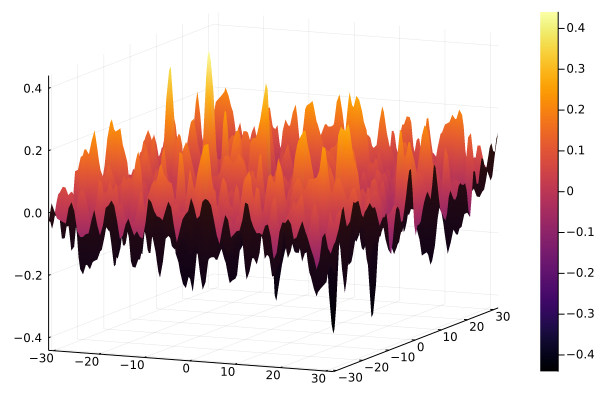

In [29]:
plot(ω3, ω3, imag((transform3_simplex_split)), st=:surface)

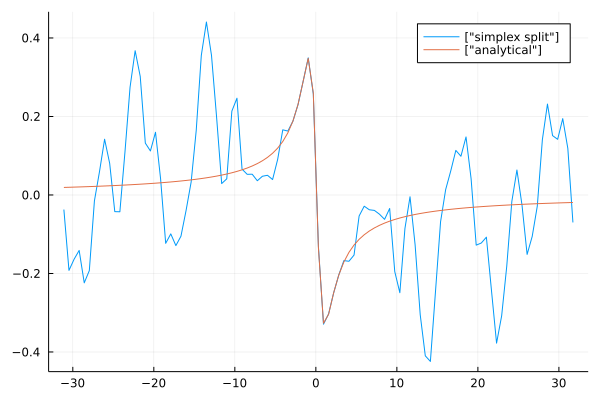

In [30]:
x_cut = 50

plot(ω3, imag(transform3_simplex_split)[x_cut,:], label = ["simplex split"])
plot!(ω3, transform3_Lehmann[x_cut,:], label = ["analytical"])